<a href="https://colab.research.google.com/github/LingfengChen-lc/VirtualPatientGenerationAnalysis/blob/main/Trauma_data_imputation_and_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Import the data

In [ ]:
# trauma_data = pd.read_excel('gdrive/My Drive/trauma-v2.xlsx',
#                               sheet_name="numerical variables- T-0",header=1)
trauma_data = pd.read_csv('gdrive/My Drive/SF_VAREXTENDED.csv')

In [ ]:
trauma_data

,iss,hr0_bun,hr6_bun,hr12_bun,hr24_bun,hr0_hgb,hr6_hgb,hr12_hgb,hr24_hgb,hr0_pt,hr6_pt,hr12_pt,hr24_pt,hr0_ptt,hr6_ptt,hr12_ptt,hr24_ptt,hr0_pc,hr6_pc,hr12_pc,hr24_pc,hr0_ddimer,hr6_ddimer,hr12_ddimer,hr24_ddimer,outcome
0,20.0,14.0,14.0,14.0,14.0,13.100000,11.000000,11.000000,10.000000,14.400000,17.200001,17.200001,17.200001,21.400000,35.400002,35.400002,35.400002,103.0,65.0,50.0,48.0,2.43,6.93,9.81,3.70,0.0
1,29.0,17.0,17.0,17.0,17.0,14.200000,14.200000,14.200000,14.200000,16.200001,14.800000,13.800000,13.800000,31.900000,33.000000,33.500000,33.500000,112.0,87.0,93.0,93.0,4.82,6.20,4.79,4.79,0.0
2,33.0,16.0,16.0,16.0,16.0,12.200000,10.700000,10.700000,10.700000,15.100000,14.400000,14.400000,14.400000,25.500000,25.700001,25.700001,25.700001,111.0,111.0,81.0,81.0,7.78,7.78,5.83,5.83,1.0
3,50.0,14.0,11.0,10.0,10.0,9.100000,8.800000,9.600000,9.600000,18.100000,18.299999,18.100000,18.100000,26.299999,40.500000,31.900000,31.900000,47.0,46.0,67.0,67.0,6.29,6.03,6.65,6.65,0.0
4,16.0,15.0,15.0,15.0,15.0,10.800000,10.100000,10.100000,10.100000,17.299999,17.799999,17.799999,17.799999,32.200001,32.700001,32.700001,32.700001,87.0,57.0,66.0,71.0,6.47,2.60,2.13,0.69,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,5.0,12.0,10.0,10.0,10.0,13.300000,12.600000,12.600000,12.600000,13.700000,15.200000,15.200000,15.200000,26.100000,26.600000,26.600000,26.600000,26.6,26.6,26.6,26.6,26.60,26.60,26.60,26.60,0.0
859,26.0,15.0,15.0,15.0,15.0,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.900000,14.9,14.9,14.9,14.9,14.90,14.90,14.90,14.90,0.0
860,14.0,16.0,16.0,16.0,16.0,14.600000,14.600000,14.600000,14.600000,11.700000,11.700000,11.700000,11.700000,24.500000,24.500000,24.500000,24.500000,24.5,24.5,24.5,24.5,24.50,24.50,24.50,24.50,0.0
861,13.0,9.0,9.0,9.0,9.0,16.200001,16.200001,16.200001,16.200001,13.100000,13.100000,13.100000,13.100000,22.400000,22.400000,22.400000,22.400000,22.4,22.4,22.4,22.4,22.40,22.40,22.40,22.40,0.0


In [ ]:
# remove duplicate columns
trauma_data = trauma_data.loc[:, :'coagulopathy_0h']
trauma_data = trauma_data[np.invert(trauma_data['mortality at disch'].isna())]  #remove rows with outcome column is nan value

In [ ]:
trauma_data['mortality at disch'].value_counts()

0.0    1213
1.0     271
Name: mortality at disch, dtype: int64

Clean the data

In [ ]:
#hepatic failure clean
trauma_data['hepatic failure'].replace('No', -1, inplace=True)
trauma_data['hepatic failure'].replace(-1, 0, inplace=True)
trauma_data['hepatic failure'].replace('Yes', 1, inplace=True)
#immuno-suppression clean
trauma_data['immuno-suppression'].replace('No', -1, inplace=True)
trauma_data['immuno-suppression'].replace(-1, 0, inplace=True)
trauma_data['immuno-suppression'].replace('Yes', 1, inplace=True)

In [ ]:
#choose columns which contain less than 500 nan values. 
features_with_less_missing = trauma_data.columns[(trauma_data.isna().sum() < 500).values]
new_data = trauma_data[features_with_less_missing].replace(-1, np.nan) #choose all data

**Impute the missing value and analyze the error**

In [ ]:
#https://scikit-learn.org/stable/modules/impute.html
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
X_train, X_test = train_test_split(new_data, test_size = 0.3, random_state=0)
y_train = X_train['mortality at disch']
X_train = X_train.loc[:, X_train.columns != 'mortality at disch']
y_test = X_test['mortality at disch']
X_test = X_test.loc[:, X_test.columns != 'mortality at disch']

In [ ]:
# X_test.iloc[10]['hr0_SBP'] = np.nan
imp = IterativeImputer(sample_posterior=True, min_value=0, random_state=0)
imp.fit(X_train)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=0, missing_values=nan,
                 n_nearest_features=None, random_state=0, sample_posterior=True,
                 skip_complete=False, tol=0.001, verbose=0)

In [ ]:
# #compute for each feature the average shift from orginal value. 
# target_featuers = X_test.loc[:,'hr0_temperature':'hr0_Protein C'].columns
# error_result = pd.Series(index=target_featuers)
# for col in target_featuers:
#   temp = X_test.copy()
#   exist = ~np.isnan(temp[col])
#   y = temp[col][exist] #all exist value
#   temp[col][exist] = np.nan
#   m = len(y)
#   inputed = pd.DataFrame(imp.transform(temp[exist]))
#   inputed.columns = temp.columns
#   error_result[col] = abs(np.mean(y - inputed[col]))
# error_result

In [ ]:
X_test.describe().to_csv('gdrive/My Drive/trauma-v3-original.csv')

In [ ]:
inputed = pd.DataFrame(imp.transform(X_test))
inputed.columns = X_test.columns
# inputed.describe().to_csv('gdrive/My Drive/trauma-v3-inputed.csv')
inputed.describe()

,male,age,race,latino,weight kg,height cm,bmi,smoking status,hiv,aids,hepatic failure,immuno-suppression,asthma,copd,ild,other chronic lung disease,cad,chf,esrd dialysis,cirrhosis,diabetes,malignancy,ais head1,ais face2,ais chest3,ais abdomen4,ais extremity5,ais skin6,iss,GCS (ED arrival),hr0_temperature,hr0_heart rate,hr0_respiratory rate,hr0_SBP,hr0_pH,hr0_serum CO2,hr0_lactate,albumin,hr0_BUN,hr0_creatinine,hr0_wbc,hr0_hgb,hr0_hct,hr0_plts,hr0_pt,hr0_ptt,hr0_inr,hr0_fibrinogen,hr0_factorii,hr0_factorv,hr0_factorix,hr0_factorviii,hr0_atiii,hr0_Protein C,total hospital days,icu_days_to 28 days,vent days_to 28 days,vent free days at 28 days,mof,thrombo embolic complication,coagulopathy_0h
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.00000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,0.825112,40.146522,1.896861,0.338130,80.145957,172.820353,26.571706,1.788103,0.068883,0.031699,0.003014,0.007415,0.085791,0.019019,0.000004,0.000643,0.037815,0.012902,0.005710,0.023741,0.063198,0.041917,1.829556,0.445385,1.214234,0.733739,0.938897,0.815799,18.500840,10.750117,36.262668,97.708024,20.113102,134.592280,7.301274,23.482693,5.142698,3.672977,15.856577,1.03976,10.713415,13.584339,40.729619,274.113510,15.136576,31.226560,1.249921,220.381886,72.952502,51.919137,122.158209,212.472204,85.493291,89.551715,12.643498,5.320628,4.179372,19.473094,0.112108,0.069507,0.192754
std,0.380298,18.013638,1.350202,0.501030,19.946225,12.150647,5.767281,1.228367,0.161571,0.112550,0.047848,0.082155,0.265194,0.120728,0.000024,0.005376,0.178568,0.097958,0.052556,0.136469,0.231353,0.185017,2.149451,0.828652,1.664309,1.363658,1.446391,0.499939,16.970439,4.714845,1.463504,25.373353,5.514770,33.459936,0.144361,4.523509,3.501727,0.951021,7.991629,0.46864,4.521335,2.074243,5.872539,86.760051,6.478020,15.747236,0.811349,144.675601,22.237745,26.863983,45.340479,158.020466,29.046556,31.213142,21.165603,8.164482,7.219768,11.477303,0.315853,0.254599,0.387436
min,0.000000,16.000000,0.000000,0.000000,33.374205,131.538832,2.380618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,30.557218,31.000000,0.281676,51.000000,6.800000,5.000000,0.106912,0.070719,1.301088,0.30000,2.597302,4.800000,15.500000,27.000000,5.187573,4.448857,0.138120,0.000000,6.000000,1.000000,0.598887,1.000000,1.761399,12.437199,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,25.250000,1.000000,0.000000,67.099998,165.000000,22.918716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,7.000000,35.654602,80.000000,16.000000,113.000000,7.230000,21.000000,2.419732,3.046219,11.000000,0.82000,7.425000,12.400000,37.299999,221.000000,13.200000,25.500000,1.000000,114.633090,58.763867,32.000000,95.778098,96.110096,67.000000,71.000000,2.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
50%,1.000000,35.000000,2.000000,0.000000,77.350002,172.699997,25.965000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000,14.000000,36.440337,96.000000,20.000000,134.000000,7.32973

In [ ]:
#final imputed dataset
imp.fit(pd.concat([X_train, X_test]))
new_data_x = new_data.loc[:, new_data.columns != 'mortality at disch']
new_data_y = new_data['mortality at disch'].reset_index(drop=True)
final = pd.DataFrame(imp.transform(new_data_x))
final.columns = new_data_x.columns
final['mortality at disch'] = new_data_y
final.describe()
# final.to_csv('gdrive/My Drive/trauma-v3.csv')

,male,age,race,latino,weight kg,height cm,bmi,smoking status,hiv,aids,hepatic failure,immuno-suppression,asthma,copd,ild,other chronic lung disease,cad,chf,esrd dialysis,cirrhosis,diabetes,malignancy,ais head1,ais face2,ais chest3,ais abdomen4,ais extremity5,ais skin6,iss,GCS (ED arrival),hr0_temperature,hr0_heart rate,hr0_respiratory rate,hr0_SBP,hr0_pH,hr0_serum CO2,hr0_lactate,albumin,hr0_BUN,hr0_creatinine,hr0_wbc,hr0_hgb,hr0_hct,hr0_plts,hr0_pt,hr0_ptt,hr0_inr,hr0_fibrinogen,hr0_factorii,hr0_factorv,hr0_factorix,hr0_factorviii,hr0_atiii,hr0_Protein C,total hospital days,icu_days_to 28 days,vent days_to 28 days,vent free days at 28 days,mof,thrombo embolic complication,coagulopathy_0h,mortality at disch
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.815748,40.561444,1.786706,0.282145,80.466910,172.818634,26.851050,1.692370,0.063696,0.032180,0.004352,0.005738,0.085345,0.022608,0.000003,0.001254,0.035449,0.014059,0.008996,0.024873,0.076885,0.042744,1.824731,0.470589,1.161625,0.742382,0.865577,0.812533,18.059630,10.911005,36.189332,97.570527,19.966015,135.979905,7.304506,23.324055,5.474061,3.638898,15.723427,1.048892,10.635356,13.646078,40.739068,273.149583,14.980875,30.712188,1.228398,284.749374,72.600675,51.299438,118.798351,212.745636,86.680864,89.478391,12.776280,4.930604,3.886961,19.861314,0.086253,0.052588,0.187863,0.182615
std,0.388597,18.520308,1.313266,0.455504,20.212905,12.072326,5.592031,1.236804,0.156664,0.098368,0.054043,0.069074,0.266729,0.134791,0.000018,0.026414,0.171431,0.102499,0.077188,0.143404,0.252331,0.189633,2.126561,0.855220,1.678238,1.363166,1.337558,0.492226,16.322503,4.733194,1.747340,25.095491,6.315916,33.690710,0.142145,4.474163,3.975849,0.866898,8.791194,0.702956,5.025637,2.201195,5.843373,85.839308,5.559351,13.532949,0.703963,190.144648,21.723394,27.963515,46.529598,153.293612,29.765834,30.391496,23.448308,7.527245,6.850272,11.284354,0.280832,0.223226,0.379278,0.386480
min,0.000000,15.000000,0.000000,0.000000,2.256710,127.000000,7.228913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.874837,29.846795,23.000000,6.000000,42.000000,6.570000,5.000000,0.000000,0.506414,2.000000,0.060129,1.759641,4.300000,13.300000,15.000000,5.020370,6.195161,0.000000,0.000000,1.513486,0.000000,0.154005,0.177505,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,25.000000,1.000000,0.000000,66.900002,165.100006,23.097500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,7.000000,35.463094,80.000000,16.000000,115.750000,7.240000,21.000000,2.500000,3.004502,11.000000,0.800000,7.300000,12.500000,37.675000,219.000000,13.200000,25.500000,1.000000,134.217217,58.628054,30.000000,88.920957,100.000000,68.065852,69.621214,2.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,2.000000,0.000000,78.648086,173.000000,26.250000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [ ]:
final['mortality at disch'].value_counts()

0.0    1213
1.0     271
Name: mortality at disch, dtype: int64

**Generate new patient data** 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras import backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras.layers import Lambda, Input, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
original_dim = final.shape[1] - 1


In [ ]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# vae_train = np.copy(final.values)
# scaler = MinMaxScaler()
# vae_train = scaler.fit_transform(vae_train)
# x_train, x_test = train_test_split(vae_train, test_size=0.5,
#                                    random_state=0,
#                                    shuffle=True)
# print(x_train.shape)
# print(x_test.shape)

(747, 74)
(747, 74)


In [ ]:
# x_train = np.reshape(x_train, [-1, original_dim])
# x_test = np.reshape(x_test, [-1, original_dim])
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# print(x_train.shape)
# print(x_test.shape)

In [ ]:
#code from https://github.com/KristianMiok/MCD-VAE/blob/master/New_MC_VAE_VAE_Comparision.ipynb
from keras.regularizers import l2
from keras.losses import categorical_crossentropy

class VAE:
    def __init__(self, input_shape=(original_dim,), 
                 intermediate_dim=128, latent_dim=2, summary=False):
        
        self._build_model(input_shape,
                         intermediate_dim, 
                          latent_dim, summary)
    
    def _build_model(self, input_shape, intermediate_dim, latent_dim,
                    summary=False):
        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        x = Dense(intermediate_dim, activation='relu')(x)
        x = Dense(intermediate_dim//2, activation='relu')(x)
        
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)

        z = Lambda(self.sampling, output_shape=(latent_dim,), 
                   name='z')([z_mean, z_log_var])

        self.encoder = Model(inputs, [z_mean, z_log_var, z], 
                        name='encoder')
        
        latent_inputs = Input(shape=(latent_dim,), 
                              name='z_sampling')
        x = latent_inputs
        x = Dense(intermediate_dim//2, activation='relu')(x)
        x = Dense(intermediate_dim, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        self.decoder = Model(latent_inputs, outputs, name='decoder')
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        vae_loss = K.mean(reconstruction_loss + kl_loss)	
        
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
        if summary: 
            print(self.vae.summary())
        
    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
    def fit(self, x_train, x_test, epochs=100, batch_size=100,
           verbose=1):
        self.vae.fit(x_train, 
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            validation_data=(x_test, None))
    
    def encoder_predict(self, x_test, batch_size=100):
        return self.encoder.predict(x_test,
                                   batch_size=batch_size)
    
    def generate(self, latent_val, batch_size=100):
        return self.decoder.predict(latent_val)
    
    def predict(self, x_test, batch_size=1):
        prediction = self.vae.predict(x_test)
        return prediction

**Visualize changes between epoch using PCA**

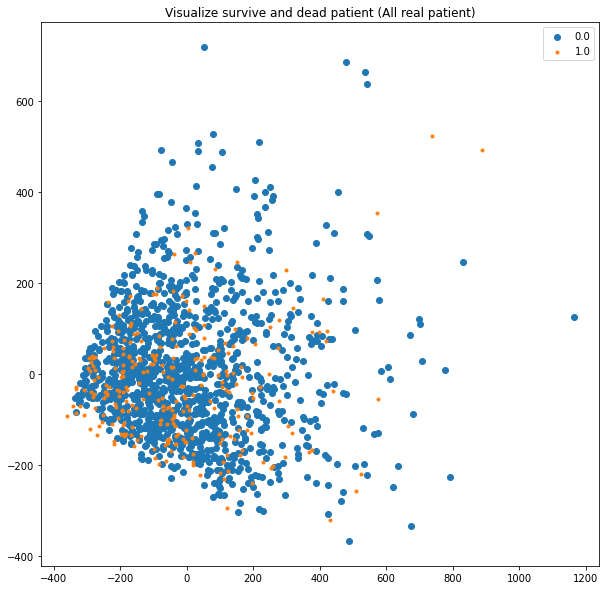

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
X = pca.fit_transform(final.loc[:, final.columns != 'mortality at disch'])
y = final['mortality at disch']
def plot_2d_space(X, y, label, axis=plt):
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', '.']
  for l, c, m in zip(np.unique(y), colors, markers):
    axis.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
  if axis == plt:
    axis.title(label)
  else:
    axis.title.set_text(label)
  axis.legend(loc='upper right')

f = plt.figure(figsize=(10,10))
plot_2d_space(X, y, 'Visualize survive and dead patient (All real patient)')

**Train VAE**

In [ ]:
#separate dataframe to two classes
scaler = MinMaxScaler()
def train_test_process(df):
  # vae_train = np.copy(df.values)
  vae_train = scaler.fit_transform(df.values)
  x_train, x_test = train_test_split(vae_train, test_size=0.3,
                                    random_state=0,
                                    shuffle=True)
  original_dim = x_train.shape[1]
  x_train = np.reshape(x_train, [-1, original_dim])
  x_test = np.reshape(x_test, [-1, original_dim])
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  return (x_train, x_test)
#class 0 train test set
df_class_0 = final[final['mortality at disch'] == 0].drop('mortality at disch', axis=1)
x_train_0, x_test_0 = train_test_process(df_class_0)
#class 1 train test set
df_class_1 = final[final['mortality at disch'] == 1].drop('mortality at disch', axis=1)
x_train_1, x_test_1 = train_test_process(df_class_1)
#respectively fit two dataframes with two VAE models
latent_dim = (len(final.columns) - 1)//2
intermediate_dim = 512
vae_0 = VAE(intermediate_dim=intermediate_dim, latent_dim=latent_dim)
vae_1 = VAE(intermediate_dim=intermediate_dim, latent_dim=latent_dim)


**generate Data**

**Group 0**

In [ ]:
epochs = [1, 10, 100]
total_nums = 2
results_0 = [[],[],[]]
for j, epoch in enumerate(epochs):
  vae_0.fit(x_train_0, x_test_0, epochs=epoch)
  x_test_0_tmp = np.reshape(x_test_0, (-1, original_dim))
  x_test_encoded_0 = vae_0.encoder.predict(x_test_0_tmp)
  x_test_encoded_0 = np.asarray(x_test_encoded_0)
  for _ in range(2):
    for i in range(x_test_encoded_0.shape[1]):
        latent_gen = []
        for _ in range(total_nums):
            epsilon = np.random.normal(0., 1., x_test_encoded_0.shape[2])
            latent_gen.extend([x_test_encoded_0[0, i, :] + np.exp(x_test_encoded_0[1, i, :]*0.5)*epsilon])
        latent_gen = np.asarray(latent_gen)
        results_0[j].append(vae_0.generate(latent_gen))
        # results.append(vae.generate(latent_gen))
      
  results_0[j] = np.asarray(results_0[j])
  results_0[j] = np.reshape(results_0[j], (-1, original_dim))
  # print(results.shape)
  results_0[j] = scaler.inverse_transform(results_0[j])
  results_0[j] = pd.DataFrame(results_0[j]) 
  results_0[j].columns = final.drop('mortality at disch', axis = 1).columns

**Group 1**

In [ ]:
epochs = [1, 10, 100]
total_nums = 2
results_1 = [[],[],[]]
for j, epoch in enumerate(epochs):
  vae_1.fit(x_train_1, x_test_1, epochs=epoch)
  x_test_1_tmp = np.reshape(x_test_1, (-1, original_dim))
  x_test_encoded_1 = vae_1.encoder.predict(x_test_1_tmp)
  x_test_encoded_1 = np.asarray(x_test_encoded_1)
  for _ in range(2):
    for i in range(x_test_encoded_1.shape[1]):
        latent_gen = []
        for _ in range(total_nums):
            epsilon = np.random.normal(0., 1., x_test_encoded_1.shape[2])
            latent_gen.extend([x_test_encoded_1[0, i, :] + np.exp(x_test_encoded_1[1, i, :]*0.5)*epsilon])
        latent_gen = np.asarray(latent_gen)
        results_1[j].append(vae_1.generate(latent_gen))
        # results.append(vae.generate(latent_gen))
      
  results_1[j] = np.asarray(results_1[j])
  results_1[j] = np.reshape(results_1[j], (-1, original_dim))
  # print(results.shape)
  results_1[j] = scaler.inverse_transform(results_1[j])
  results_1[j] = pd.DataFrame(results_1[j]) 
  results_1[j].columns = final.drop('mortality at disch', axis = 1).columns

In [ ]:
# x_test_0_tmp = np.reshape(x_test_0, (-1, original_dim))
# x_test_encoded_0 = vae_0.encoder.predict(x_test_0_tmp)
# x_test_encoded_0 = np.asarray(x_test_encoded_0)

# print(x_test_encoded_0.shape)
# x_test_1_tmp = np.reshape(x_test_1, (-1, original_dim))
# x_test_encoded_1 = vae_1.encoder.predict(x_test_1_tmp)
# x_test_encoded_1 = np.asarray(x_test_encoded_1)

# print(x_test_encoded_1.shape)

(3, 367, 37)
(3, 82, 37)


In [ ]:
# total_nums = 2
# results = []
# for _ in range(2):
#   for i in range(x_test_encoded_0.shape[1]):
#       latent_gen = []
#       for _ in range(total_nums):
#           epsilon = np.random.normal(0., 1., x_test_encoded_0.shape[2])
#           latent_gen.extend([x_test_encoded_0[0, i, :] + np.exp(x_test_encoded_0[1, i, :]*0.5)*epsilon])
#       latent_gen = np.asarray(latent_gen)
#       results.append(vae_0.generate(latent_gen))
#       # results.append(vae.generate(latent_gen))
    
# results = np.asarray(results)
# results = np.reshape(results, (-1, original_dim))
# print(results.shape)
# results = scaler.inverse_transform(results)

(1468, 74)


In [ ]:
# results = pd.DataFrame(results) 
# results.columns = final.columns

In [ ]:
# results.to_csv('gdrive/My Drive/trauma-v3-generated.csv')
# results.describe().to_csv('gdrive/My Drive/trauma-v3-generated-describe.csv')
# results.describe()

**Visualize**


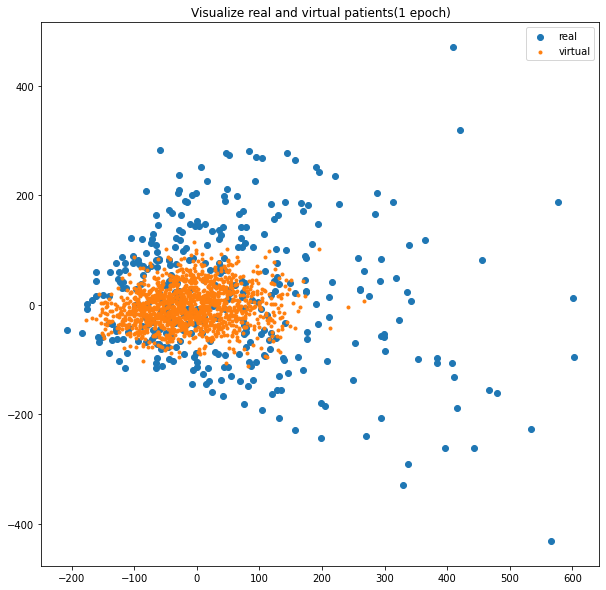

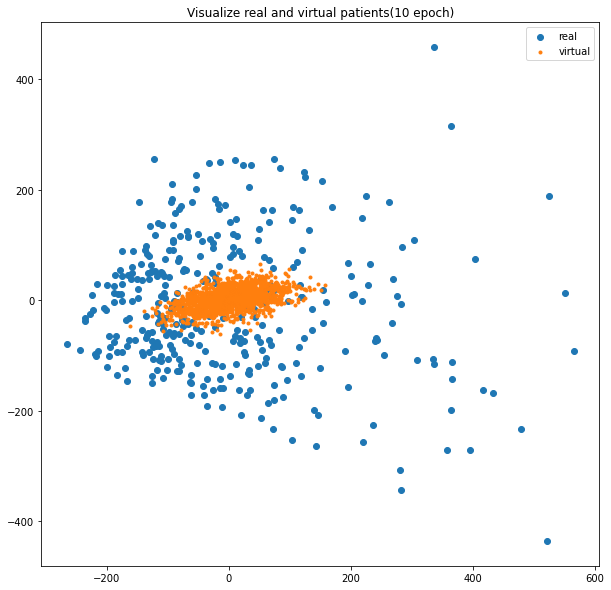

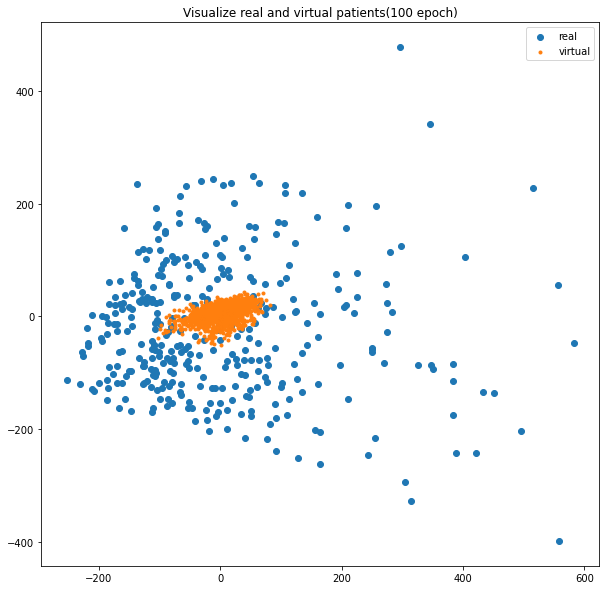

In [ ]:
def produce_x_y(real_df, virtual_df, epoch=100):
  #transform real_df to original form
  real_df = scaler.inverse_transform(real_df)
  real_df = pd.DataFrame(real_df) 
  real_df.columns = final.drop('mortality at disch', axis=1).columns
  #concat new_df and visualize
  real_df['if virtual'] = 'real'
  virtual_df['if virtual'] = 'virtual'
  new_df = pd.concat([real_df, virtual_df])
  pca = PCA(n_components=2, random_state=0)
  X = pca.fit_transform(new_df.loc[:, new_df.columns != 'if virtual'])
  y = new_df['if virtual']
  return (X, y)
#visualize 3 graphs
for i, epoch in enumerate(epochs):
  X, y = produce_x_y(x_test_0, results_0[i])
  f = plt.figure(figsize=(10,10))
  text = f"Visualize real and virtual patients({epoch} epoch)"
  plot_2d_space(X, y, text)


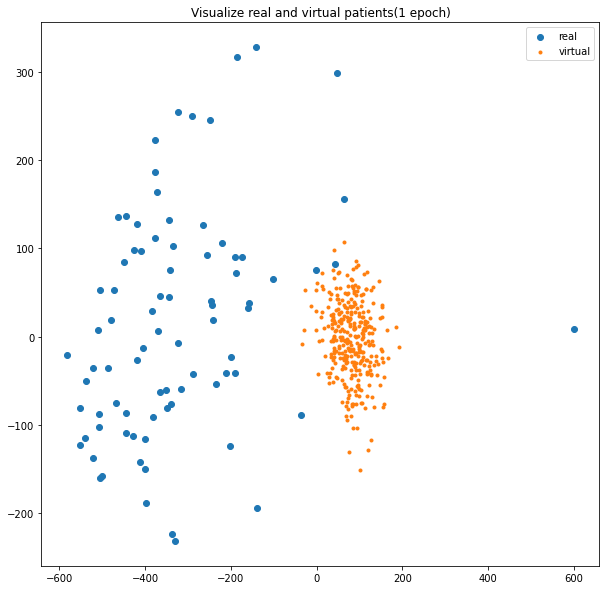

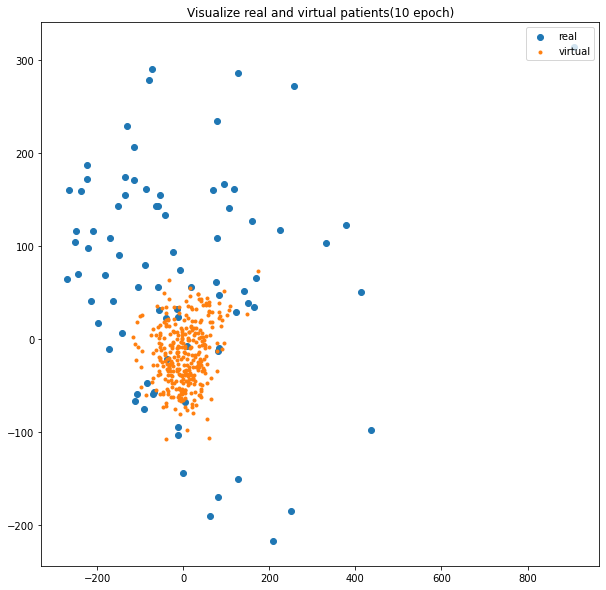

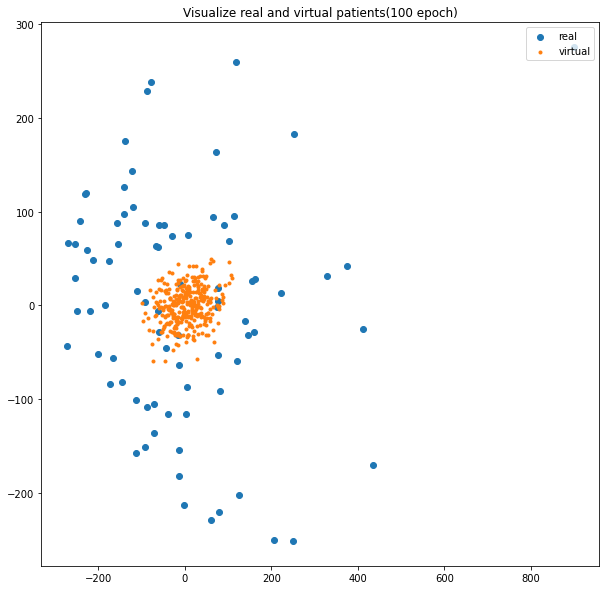

In [ ]:
#visualize 3 graphs for group 1
for i, epoch in enumerate(epochs):
  X, y = produce_x_y(x_test_1, results_1[i])
  f = plt.figure(figsize=(10,10))
  text = f"Visualize real and virtual patients({epoch} epoch)"
  plot_2d_space(X, y, text)

**Test if virtual patients help improve accuracy of a base model**

In [ ]:
#base model: Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
rfc = RandomForestClassifier(n_estimators = 59, max_depth = 10, random_state = 0)

In [ ]:
# classify based on real patient
X = final.loc[:, final.columns != 'mortality at disch']
y = final['mortality at disch']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'mean accuracy is {accuracy_score(y_pred, y_test)}')
print(confusion_matrix(y_pred, y_test))

mean accuracy is 0.9708520179372198
[[359  10]
 [  3  74]]


In [ ]:
#train with virtual and test with real ... And visualization ... including n numbers of virtual patient ... predict on only real ... For

# classify based on real + virtual patient, concat dataframe 
results_0[2] = results_0[2].loc[:, results_0[2].columns != 'if virtual']
results_0[2]['mortality at disch'] = 0
results_1[2] = results_1[2].loc[:, results_1[2].columns != 'if virtual']
results_1[2]['mortality at disch'] = 1
real_and_virtual_df = pd.concat([final, results_0[2], results_1[2]])

# set threshold for 'mortality at dish'
real_and_virtual_df['mortality at disch'][real_and_virtual_df['mortality at disch'] < 0.5] = 0
real_and_virtual_df['mortality at disch'][real_and_virtual_df['mortality at disch'] > 0.5] = 1
np.unique(real_and_virtual_df['mortality at disch'])

# classify (add 328 class 1 virtual patient and 1468 class 0 virtual patient)
X = real_and_virtual_df.loc[:, real_and_virtual_df.columns != 'mortality at disch']
y = real_and_virtual_df['mortality at disch']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'mean accuracy is {accuracy_score(y_pred, y_test)}')
print(confusion_matrix(y_pred, y_test))

mean accuracy is 0.9887869520897044
[[781   7]
 [  4 189]]


In [ ]:
#train on virtual patient and test of real patient
n_train = X_train.shape[0]
n_test = X_test.shape[0]
virtual_patients = pd.concat([results_0[2], results_1[2]])
# set threshold for virtual_patients 'mortality at disch'
virtual_patients['mortality at disch'][virtual_patients['mortality at disch'] < 0.5] = 0
virtual_patients['mortality at disch'][virtual_patients['mortality at disch'] > 0.5] = 1
n_virtual = virtual_patients.shape[0]
n_real = final.shape[0]
print('Percentage of test case: ', n_real / (n_virtual + n_real)* 100.0)

X_train = virtual_patients.loc[:, virtual_patients.columns != 'mortality at disch']
y_train = virtual_patients['mortality at disch']

X_test = final.loc[:, final.columns != 'mortality at disch']
y_test = final['mortality at disch']

# classify
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'mean accuracy is {accuracy_score(y_pred, y_test)}')
print(confusion_matrix(y_pred, y_test))

# train on virtual+real patient and only test on real patient
cut_off = (n_real + n_virtual)*0.3
real_test_case = final.loc[:cut_off-1, :]
X_test = real_test_case.loc[:, real_test_case.columns != 'mortality at dish']
y_test = real_test_case['mortality at disch']
virtual_plus_real_train_case = pd.concat([final.loc[cut_off:, :], virtual_patients]) 
X_train = virtual_plus_real_train_case.loc[:, virtual_plus_real_train_case.columns != 'mortality at dish']
y_train = virtual_plus_real_train_case['mortality at disch']
# classify
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(f'mean accuracy is {accuracy_score(y_pred, y_test)}')
print(confusion_matrix(y_pred, y_test))

Percentage of test case:  45.41003671970624
mean accuracy is 0.42183288409703507
[[374  19]
 [839 252]]
mean accuracy is 1.0
[[768   0]
 [  0 212]]


**Different VAE Implementation**

In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import keras.backend as K
import tensorflow as tf

m = 50
n_z = 45
n_epoch = 150
# x_0 = final.shape[1]
x_0 = 784

# Q(z|X) -- encoder
inputs = Input(shape=(x_0,))
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [ ]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

In [ ]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(x_0, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In [ ]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [ ]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [ ]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(final, final, batch_size=m, epochs=n_epoch)

**Read Time Series data** 

In [ ]:
time_series_data = pd.read_excel('gdrive/My Drive/SF_TimeSeries.xlsx')

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)
outcome = time_series_data['outcome']
time_series_data = time_series_data.iloc[:,:-1]
imp.fit(time_series_data) #without outcome column
# IterativeImputer(random_state=0)
# test = np.array(df_train.loc[194].values.tolist())
imputed_time_series_data = pd.DataFrame(imp.transform(time_series_data))
imputed_time_series_data.columns = time_series_data.columns

In [ ]:
imputed_time_series_data